In [5]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "src")))

In [18]:
from langchain_ollama import ChatOllama
import json
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults

from typing import List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END

from config import setup_env, RAG_Config
from utils import test_router_prompt, test_relevance_prompt, concatenate_docs
from prompts import ROUTER_SYSTEM_PROMPT, ROUTER_USER_PROMPT, RELEVANCE_SYSTEM_PROMPT, RELEVANCE_USER_PROMPT, RAG_QA_PROMPT, HALLUCINATION_SYSTEM_PROMPT, HALLUCINATION_USER_PROMPT


setup_env()
rag_config = RAG_Config()

# Chat model for inference
local_llm = rag_config.ollama_model
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

# Sanity check the prompts
if rag_config.verify_prompts:
    print("Verifying prompts...")
    test_router_prompt(llm_json_mode)
    test_relevance_prompt(llm_json_mode)
    print("Prompts checks passed.")


######################### Create vector DB and get corresponding retriever #########################
# Load documents
docs = WebBaseLoader(rag_config.vectordb_urls).load()

# Split documents based on number of tokens
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="gpt2",
    chunk_size=500,
    chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs)

# Add to vectorDB and create retriever
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)
retriever = vectorstore.as_retriever(k=3)

# Web search tool
web_search_tool = TavilySearchResults(k=3)


######################### Create LangGraph for the RAG Agent #########################
class GraphState(TypedDict):
    '''State of the current node in the graph as a dictionary'''
    question: str
    web_search_needed: bool
    documents: List[str]
    answer: str
    num_retries: int
    max_retries: int


############### Graph Nodes ###############
def retrieve_from_vector_db(state):
    '''Retrieve relevant docs from vector database based on the state'''
    print("## RETRIEVE ##")
    documents = retriever.invoke(state["question"])
    documents = [document.page_content for document in documents]
    return {"documents": documents}

def check_relevance(state):
    '''Check if the retrieved documents are relevant to the question'''
    print("## CHECK RELEVANCE ##")
    relevant_docs = []
    web_search_needed = True

    for document in state["documents"]:
        user_prompt_formatted = RELEVANCE_USER_PROMPT.format(document=document, question=state["question"])
        result = llm_json_mode.invoke(
            [SystemMessage(content=RELEVANCE_SYSTEM_PROMPT)] + [HumanMessage(content=user_prompt_formatted)]
        )
        is_relevant = json.loads(result.content)['relevant']
        if is_relevant == "yes":
            relevant_docs.append(document)
            web_search_needed = False
    return {"documents": relevant_docs, "web_search_needed": web_search_needed}

def web_search(state):
    '''Search for additional information using web search'''
    print("## WEB SEARCH ##")
    documents = state.get("documents", [])
    search_results = web_search_tool.invoke(state["question"])
    web_search_results = [result['content'] for result in search_results]
    return {"documents": documents + web_search_results}

def generate_answer(state):
    '''Generate an answer based on the current state'''
    print("## GENERATE ANSWER ##")
    documents_text = concatenate_docs(state["documents"])
    rag_prompt_formatted = RAG_QA_PROMPT.format(context=documents_text, question=state["question"])
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    num_retries = state.get("num_retries", 0)
    return {"answer": generation.content, "num_retries": num_retries + 1}


############### Graph Edges ###############
def route_question(state):
    '''Whether to route question to VectorDB or WebSearch'''
    print("## ROUTE QUESTION ##")
    user_prompt_formatted = ROUTER_USER_PROMPT.format(question=state["question"])
    result = llm_json_mode.invoke(
        [SystemMessage(content=ROUTER_SYSTEM_PROMPT)] + [HumanMessage(content=user_prompt_formatted)]
    )
    datasource = json.loads(result.content)['datasource']
    print(f"Datasource: {datasource}")
    return datasource

def get_more_context_or_generate_answer(state):
    '''Whether to generate answer or do web search to get more context'''
    if state["web_search_needed"]:
        print("Web search needed")
        return "do_websearch"
    print("No web search needed")
    return "generate_answer"

def check_hallucination(state):
    '''Check if hallucinations are present in the answer'''
    print("## CHECKING HALLUCINATION ##")
    documents_text = concatenate_docs(state["documents"])
    hallucination_grader_prompt_formatted = HALLUCINATION_USER_PROMPT.format(
        documents=documents_text, generation=state["answer"]
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=HALLUCINATION_SYSTEM_PROMPT)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )

    evaluation = json.loads(result.content)['binary_evaluation']
    if evaluation == "bad" and state["num_retries"] >= state["max_retries"]:
        print("Max retries exceeded. Exiting.")
        return "max_retries_exceeded"
    if evaluation == "good":
        print(f"Answer is good. No hallucination detected. Exiting.")
        return "good"
    print(f"Answer is bad. Hallucination detected. Retry.")
    return "bad"


############### Create the workflow ###############
workflow = StateGraph(GraphState)
workflow.add_node("Retrieve from VectorDB", retrieve_from_vector_db)
workflow.add_node("Check Relevance", check_relevance)
workflow.add_node("Web Search", web_search)
workflow.add_node("Generate Answer", generate_answer)

workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "Web Search",
        "vectorstore": "Retrieve from VectorDB"
    },
)
workflow.add_edge("Retrieve from VectorDB", "Check Relevance")
workflow.add_conditional_edges(
    "Check Relevance",
    get_more_context_or_generate_answer,
    {
        "do_websearch": "Web Search",
        "generate_answer": "Generate Answer"
    }
)
workflow.add_edge("Web Search", "Generate Answer")
workflow.add_conditional_edges(
    "Generate Answer",
    check_hallucination,
    {
        "good": END,
        "bad": "Web Search",
        "max_retries_exceeded": END
    }
)

Verifying prompts...
Prompts checks passed.


Embedding texts: 100%|██████████| 28/28 [00:04<00:00,  5.69inputs/s]


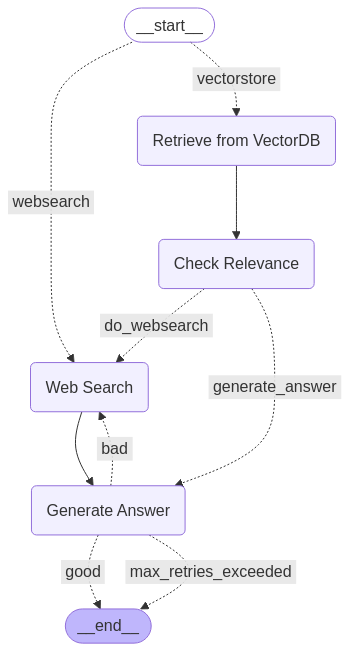

In [19]:
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
inputs = {"question": "What's a large language model?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)


## ROUTE QUESTION ##
Datasource: websearch
{'question': "What's a large language model?", 'max_retries': 3}
## WEB SEARCH ##
{'question': "What's a large language model?", 'documents': ['A large language model (LLM) is a type of machine learning model designed for natural language processing tasks such as language generation. LLMs are language models with many parameters, and are trained with self-supervised learning on a vast amount of text. [...] The largest and most capable LLMs are generative pretrained transformers (GPTs). Modern models can be fine-tuned for specific tasks or guided by prompt engineering.[1] These models acquire predictive power regarding syntax, semantics, and ontologies[2] inherent in human language corpora, but they also inherit inaccuracies and biases present in the data they are trained in.[3]\nHistory\n[edit] [...] The training compute of notable large AI models in FLOPs vs publication date over the period 2017-2024. The majority of large models are language

In [21]:
inputs = {"question": "Which teams have won the ODI world cups?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)


## ROUTE QUESTION ##
Datasource: vectorstore
{'question': 'Which teams have won the ODI world cups?', 'max_retries': 3}
## RETRIEVE ##


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 34.09inputs/s]

{'question': 'Which teams have won the ODI world cups?', 'documents': ['Also Read: Why Amul is investing heavily in international cricket teams like USA CricketCricket World Cup Winners ListThe list here shows the list of all ICC ODI World Cup winners from 1975 to 2023.\r\n\r\n\r\n\n\n\nWorld Cup Year\nWinner\nRunner Up\n\n\n\n\n2023\nAustralia\nIndia\n\n\n2019\nEngland\nNew Zealand\n\n\n2015\nAustralia\nNew Zealand\n\n\n2011\nIndia\nSri Lanka\n\n\n2007\nAustralia\nSri Lanka\n\n\n2003\nAustralia\nIndia\n\n\n1999\nAustralia\nPakistan\n\n\n1996\nSri Lanka\nAustralia\n\n\n1992\nPakistan\nEngland\n\n\n1987\nAustralia\nEngland\n\n\n1983\nIndia\nWest Indies\n\n\n1979\nWest Indies\nEngland\n\n\n1975\nWest Indies\nAustralia', "Home\nExplainers\nExplainers\nICC ODI Cricket World Cup winners list (1975 to 2023): Australia, India, West Indies and more\n\n\n\nICC ODI Cricket World Cup winners list (1975 to 2023): Australia, India, West Indies and more\n\nRelive the thrill of the Cricket World Cup 

No web search needed
{'question': 'Which teams have won the ODI world cups?', 'web_search_needed': False, 'documents': ['Also Read: Why Amul is investing heavily in international cricket teams like USA CricketCricket World Cup Winners ListThe list here shows the list of all ICC ODI World Cup winners from 1975 to 2023.\r\n\r\n\r\n\n\n\nWorld Cup Year\nWinner\nRunner Up\n\n\n\n\n2023\nAustralia\nIndia\n\n\n2019\nEngland\nNew Zealand\n\n\n2015\nAustralia\nNew Zealand\n\n\n2011\nIndia\nSri Lanka\n\n\n2007\nAustralia\nSri Lanka\n\n\n2003\nAustralia\nIndia\n\n\n1999\nAustralia\nPakistan\n\n\n1996\nSri Lanka\nAustralia\n\n\n1992\nPakistan\nEngland\n\n\n1987\nAustralia\nEngland\n\n\n1983\nIndia\nWest Indies\n\n\n1979\nWest Indies\nEngland\n\n\n1975\nWest Indies\nAustralia', "Home\nExplainers\nExplainers\nICC ODI Cricket World Cup winners list (1975 to 2023): Australia, India, West Indies and more\n\n\n\nICC ODI Cricket World Cup winners list (1975 to 2023): Australia, India, West Indies and mo